# Figure 1 Replication - Event-Time Leverage Paths

Replicates Figure 1 from Lemmon, Roberts, and Zender (2008).


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

pd.set_option('display.precision', 3)


## STEP 1 — Load and Filter Data (Paper's Exact Rules)

Filters: `indfmt=INDL`, `datafmt=STD`, `consol=C`, fyear 1965-2003, `at>0`, exclude SIC 6000-6999, **both** book and market leverage in [0,1].


In [23]:
# Load raw data from Q5
df = pd.read_csv('../Q5/data/01_raw_data.csv')
print(f"Raw data: {len(df):,} obs")

# Apply paper's filters
df = df[df['indfmt'] == 'INDL']
df = df[df['datafmt'] == 'STD']
df = df[df['consol'] == 'C']
df = df[df['fyear'].between(1965, 2003)]
df = df[df['at'] > 0]
df = df[df['sic'].notna()]
df = df[(df['sic'] < 6000) | (df['sic'] > 6999)]  # Exclude financials
print(f"After basic filters: {len(df):,} obs")

# Construct leverage variables
df['dlc'] = df['dlc'].fillna(0)
df['dltt'] = df['dltt'].fillna(0)
df['debt'] = df['dlc'] + df['dltt']
df['book_lev'] = df['debt'] / df['at']

df['me'] = df['prcc_f'] * df['csho']
df['market_lev'] = df['debt'] / (df['debt'] + df['me'])

# Paper requires BOTH leverages in [0,1] for portfolio formation
df = df[df['book_lev'].between(0, 1)]
df = df[df['market_lev'].between(0, 1)]
print(f"After leverage filters [0,1]: {len(df):,} obs")
print(f"Unique firms: {df['gvkey'].nunique():,}")
print(f"Years: {df['fyear'].min()}-{df['fyear'].max()}")


Raw data: 241,927 obs
After basic filters: 225,614 obs
After leverage filters [0,1]: 176,817 obs
Unique firms: 17,304
Years: 1965-2003


## STEP 2 — Prepare Data

Survivors are defined per formation year: only firms with data in ALL 20 event years (t0 to t0+19) are included.


In [24]:
# Just copy the data - survivor filtering happens inside the function
df_all = df.copy()

print(f"All Firms: {len(df_all):,} obs, {df_all['gvkey'].nunique():,} firms")


All Firms: 176,817 obs, 17,304 firms


## STEP 3 — Event-Time Portfolio Function

Key methodology:
1. Each formation year t0: compute quartile cutoffs, assign firms, hold fixed
2. Track firms for event years 0..19 (firms drop out naturally if they exit)
3. For each event year: compute mean per portfolio per formation year
4. Average those means across formation years (equal weight per formation year)
5. CI = mean ± 2 * (average SE across formation years)

**For Survivors: only form portfolios through 1984** (so 20-year horizon fits in 2003).


In [25]:
PORT_LABELS = ['Low', 'Medium', 'High', 'Very High']

def build_event_time_paths(df, lev_col, max_formation_year=2003, horizon=19, survivors_only=False):
    """
    Build event-time leverage paths per the paper's methodology.
    
    - survivors_only: if True, only include firms with data in ALL event years (t0 to t0+19)
    """
    df = df[['gvkey', 'fyear', lev_col]].dropna().copy()
    
    all_means = []
    all_ses = []
    
    for t0 in range(1965, max_formation_year + 1):
        # Get firms in formation year
        base = df[df['fyear'] == t0][['gvkey', lev_col]].drop_duplicates('gvkey')
        
        # For survivors: only keep firms with data in ALL 20 event years
        if survivors_only:
            required_years = set(range(t0, t0 + horizon + 1))
            firm_years = df.groupby('gvkey')['fyear'].apply(set)
            survivor_firms = firm_years[firm_years.apply(lambda x: required_years.issubset(x))].index
            base = base[base['gvkey'].isin(survivor_firms)]
        
        if len(base) < 100:
            continue
        
        # Sort and assign quartiles
        base = base.sort_values([lev_col, 'gvkey']).reset_index(drop=True)
        base['rank'] = range(len(base))
        base['quartile'] = pd.cut(base['rank'], bins=4, labels=PORT_LABELS)
        
        port_map = base.set_index('gvkey')['quartile']
        
        # Track through event years
        means_k = pd.DataFrame(index=range(horizon + 1), columns=PORT_LABELS, dtype=float)
        ses_k = pd.DataFrame(index=range(horizon + 1), columns=PORT_LABELS, dtype=float)
        
        for k in range(horizon + 1):
            yr = t0 + k
            if yr > 2003:
                break
            
            tmp = df[df['fyear'] == yr].copy()
            tmp['port'] = tmp['gvkey'].map(port_map)
            tmp = tmp.dropna(subset=['port', lev_col])
            
            if len(tmp) == 0:
                continue
            
            g = tmp.groupby('port', observed=True)[lev_col]
            for p in PORT_LABELS:
                if p in g.groups:
                    means_k.loc[k, p] = g.get_group(p).mean()
                    n = len(g.get_group(p))
                    ses_k.loc[k, p] = g.get_group(p).std(ddof=1) / np.sqrt(n) if n > 1 else np.nan
        
        all_means.append(means_k)
        all_ses.append(ses_k)
    
    # Average across formation years
    mean_path = pd.concat(all_means).groupby(level=0).mean()
    avg_se = pd.concat(all_ses).groupby(level=0).mean()
    
    ci_lo = mean_path - 2 * avg_se
    ci_hi = mean_path + 2 * avg_se
    
    return mean_path, ci_lo, ci_hi

print("Function defined.")


Function defined.


## STEP 4 — Compute All Four Panels


In [26]:
print("Computing Panel A: Book leverage, All firms...")
A_mean, A_lo, A_hi = build_event_time_paths(df_all, 'book_lev', max_formation_year=2003)

print("Computing Panel B: Book leverage, Survivors...")
B_mean, B_lo, B_hi = build_event_time_paths(df_all, 'book_lev', max_formation_year=1984, survivors_only=True)

print("Computing Panel C: Market leverage, All firms...")
C_mean, C_lo, C_hi = build_event_time_paths(df_all, 'market_lev', max_formation_year=2003)

print("Computing Panel D: Market leverage, Survivors...")
D_mean, D_lo, D_hi = build_event_time_paths(df_all, 'market_lev', max_formation_year=1984, survivors_only=True)

print("\nAll panels computed.")


Computing Panel A: Book leverage, All firms...
Computing Panel B: Book leverage, Survivors...
Computing Panel C: Market leverage, All firms...
Computing Panel D: Market leverage, Survivors...

All panels computed.


## STEP 5 — Plot Figure 1


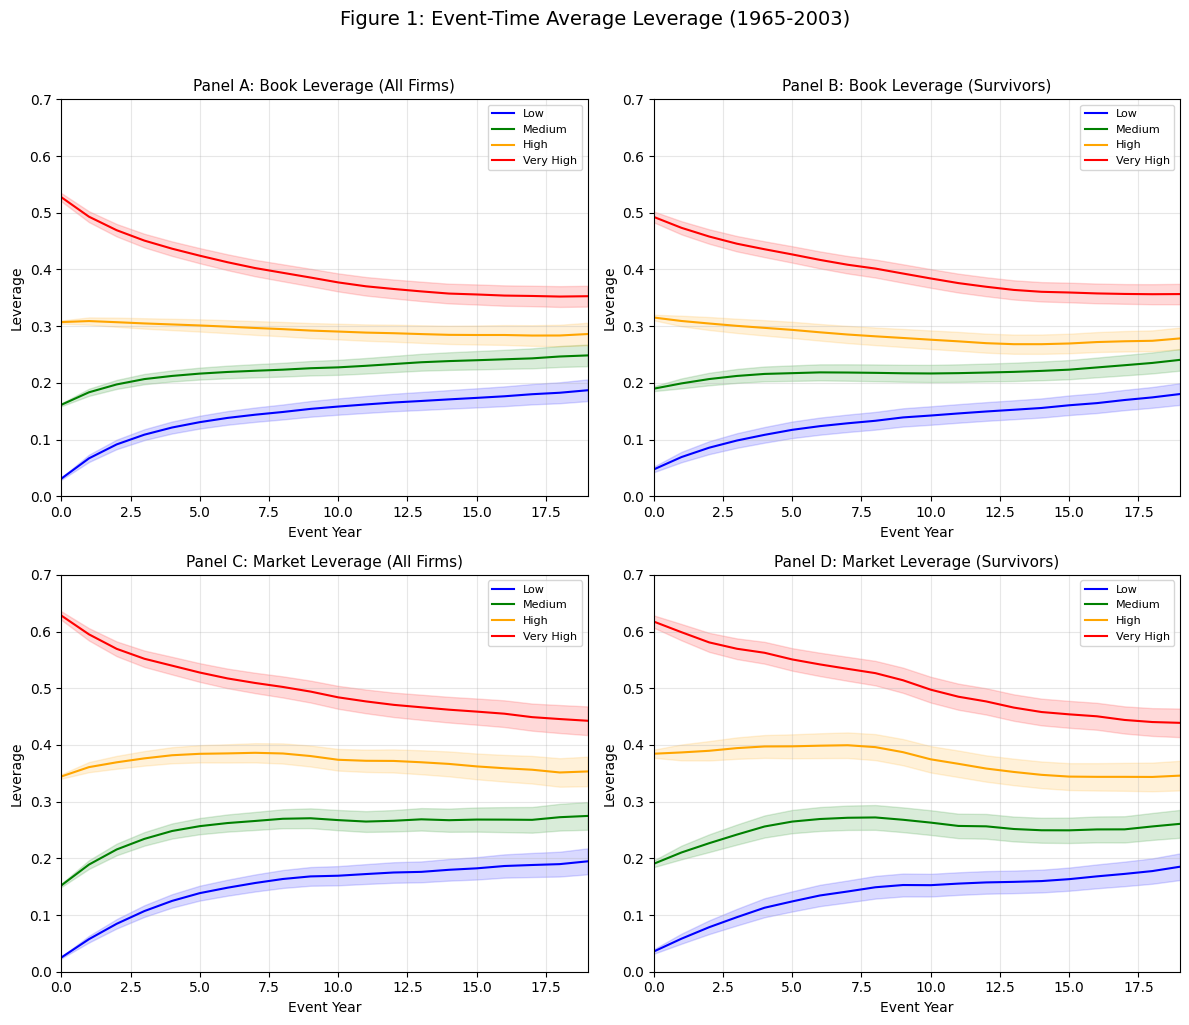


Figure saved to output/figure1_replication.png


In [27]:
def plot_panel(ax, mean_df, lo_df, hi_df, title):
    colors = ['blue', 'green', 'orange', 'red']
    for i, port in enumerate(PORT_LABELS):
        x = mean_df.index
        y = mean_df[port]
        lo = lo_df[port]
        hi = hi_df[port]
        ax.plot(x, y, color=colors[i], linewidth=1.5, label=port)
        ax.fill_between(x, lo, hi, color=colors[i], alpha=0.15)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Event Year')
    ax.set_ylabel('Leverage')
    ax.set_xlim(0, 19)
    ax.set_ylim(0, 0.7)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_panel(axes[0,0], A_mean, A_lo, A_hi, 'Panel A: Book Leverage (All Firms)')
plot_panel(axes[0,1], B_mean, B_lo, B_hi, 'Panel B: Book Leverage (Survivors)')
plot_panel(axes[1,0], C_mean, C_lo, C_hi, 'Panel C: Market Leverage (All Firms)')
plot_panel(axes[1,1], D_mean, D_lo, D_hi, 'Panel D: Market Leverage (Survivors)')

plt.suptitle('Figure 1: Event-Time Average Leverage (1965-2003)', fontsize=14, y=1.02)
plt.tight_layout()

os.makedirs('output', exist_ok=True)
plt.savefig('output/figure1_replication.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to output/figure1_replication.png")


## STEP 6 — Summary Statistics


In [28]:
print("="*60)
print("PANEL A: BOOK LEVERAGE (ALL FIRMS)")
print("="*60)
print(f"Event Year 0: Low={A_mean.loc[0,'Low']:.3f}, VeryHigh={A_mean.loc[0,'Very High']:.3f}, Spread={A_mean.loc[0,'Very High']-A_mean.loc[0,'Low']:.3f}")
print(f"Event Year 19: Low={A_mean.loc[19,'Low']:.3f}, VeryHigh={A_mean.loc[19,'Very High']:.3f}, Spread={A_mean.loc[19,'Very High']-A_mean.loc[19,'Low']:.3f}")
spread_0 = A_mean.loc[0,'Very High'] - A_mean.loc[0,'Low']
spread_19 = A_mean.loc[19,'Very High'] - A_mean.loc[19,'Low']
print(f"Convergence: {(1 - spread_19/spread_0)*100:.1f}%")

print()
print("="*60)
print("PANEL B: BOOK LEVERAGE (SURVIVORS)")
print("="*60)
print(f"Event Year 0: Low={B_mean.loc[0,'Low']:.3f}, VeryHigh={B_mean.loc[0,'Very High']:.3f}, Spread={B_mean.loc[0,'Very High']-B_mean.loc[0,'Low']:.3f}")
print(f"Event Year 19: Low={B_mean.loc[19,'Low']:.3f}, VeryHigh={B_mean.loc[19,'Very High']:.3f}, Spread={B_mean.loc[19,'Very High']-B_mean.loc[19,'Low']:.3f}")
spread_0_s = B_mean.loc[0,'Very High'] - B_mean.loc[0,'Low']
spread_19_s = B_mean.loc[19,'Very High'] - B_mean.loc[19,'Low']
print(f"Convergence: {(1 - spread_19_s/spread_0_s)*100:.1f}%")


PANEL A: BOOK LEVERAGE (ALL FIRMS)
Event Year 0: Low=0.031, VeryHigh=0.527, Spread=0.496
Event Year 19: Low=0.187, VeryHigh=0.353, Spread=0.166
Convergence: 66.6%

PANEL B: BOOK LEVERAGE (SURVIVORS)
Event Year 0: Low=0.047, VeryHigh=0.493, Spread=0.445
Event Year 19: Low=0.180, VeryHigh=0.357, Spread=0.176
Convergence: 60.4%
